#Подключение библиотек

In [ ]:
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.utils import img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import sklearn

import time
import os

from PIL import Image

In [ ]:
num_classes = 15 # hair, cloth, nose, mouth, u_lip, l_lip, r_eye, l_eye, r_ear, l_ear, r_brow, l_brow, skin, neck

#Функции

In [ ]:
def color2index(color):
    index = -1

    if color[0] == 75 and color[1] == 40 and color[2] == 15:
        index = 0  # hair
    elif color[0] == 200 and color[1] == 215 and color[2] == 105:
        index = 1  # cloth
    elif color[0] == 175 and color[1] == 140 and color[2] == 90:
        index = 2  # nose
    elif color[0] == 230 and color[1] == 230 and color[2] == 230:
        index = 3  # mouth
    elif color[0] == 255 and color[1] == 55 and color[2] == 85:
        index = 4  # u_lip
    elif color[0] == 210 and color[1] == 45 and color[2] == 70:
        index = 5  # l_lip
    elif color[0] == 250 and color[1] == 250 and color[2] == 250:
        index = 6  # r_eye
    elif color[0] == 245 and color[1] == 245 and color[2] == 245:
        index = 7  # l_eye
    elif color[0] == 200 and color[1] == 180 and color[2] == 150:
        index = 8  # r_ear
    elif color[0] == 200 and color[1] == 170 and color[2] == 130:
        index = 9  # l_ear
    elif color[0] == 55 and color[1] == 35 and color[2] == 20:
        index = 10  # r_brow
    elif color[0] == 45 and color[1] == 25 and color[2] == 10:
        index = 11  # l_brow
    elif color[0] == 225 and color[1] == 190 and color[2] == 145:
        index = 12  # skin
    elif color[0] == 170 and color[1] == 145 and color[2] == 110:
        index = 13  # neck

    return index

#индекс в цвет
def index2color(index2):
    index = np.argmax(index2)
    color = [0, 0, 0]
    if index == 0:
        color = [75, 40, 15]
    elif index == 1:
        color = [200, 215, 105]
    elif index == 2:
        color = [175, 140, 90]
    elif index == 3:
        color = [230, 230, 230]
    elif index == 4:
        color = [255, 55, 85]
    elif index == 5:
        color = [210, 45, 70]
    elif index == 6:
        color = [250, 250, 250]
    elif index == 7:
        color = [245, 245, 245]
    elif index == 8:
        color = [200, 180, 150]
    elif index == 9:
        color = [200, 170, 130]
    elif index == 10:
        color = [55, 35, 20]
    elif index == 11:
        color = [45, 25, 10]
    elif index == 12:
        color = [225, 190, 145]
    elif index == 13:
        color = [170, 145, 110]

    return color

#в one hot encoding
def rgb2ohe(y, num_classes):
    y_shape = y.shape
    y = y.reshape(y.shape[0] * y.shape[1], 3)
    yt = []

    for i in range(len(y)):
        yt.append(utils.to_categorical(color2index(y[i]), num_classes=num_classes))
    yt = np.array(yt)
    yt = yt.reshape(y_shape[0], y_shape[1], num_classes)
    return yt

#функция подготовки y
def yt_prep(data, num_classes):
    yTrain = []
    for seg in data:
        y = img_to_array(seg)
        y = rgb2ohe(y, num_classes)
        yTrain.append(y)
        if len(yTrain) % 10 == 0:
            print(len(yTrain))
    return np.array(yTrain)

#функция ошибки
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

#функция предикта
def pred(img):
  pred1 = model.predict(img)
  pr = pred1[0]
  pr1 = []
  pr = pr.reshape(-1, num_classes)
  for k in range(len(pr)):
      pr1.append(index2color(pr[k]))
  pr1 = np.array(pr1)
  seg = pr1.reshape(256, 256, 3)
  return seg

In [ ]:
#модель Unet с 4 блоками
def unet(num_classes=15, input_shape=(512, 512, 3)):
    img_input = Input(input_shape)  # Создаем входной слой с размерностью input_shape

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out)

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    block_4_out = Activation('relu')(x)
    x = block_4_out

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)  #модель с входом 'img_input' и выходом 'x'

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[dice_coef])

    return model

#Загрузка и преобразование

Загрузка двух ZIP файлов с облака, 2_000 изображений

In [ ]:
import zipfile
from google.colab import drive
from PIL import Image
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
zip_file_images = "/content/drive/MyDrive/База/Images.zip"
zip_file_segments = "/content/drive/MyDrive/База/Segments.zip"

In [ ]:
#вытаскиваю изображения в папки

z_img = zipfile.ZipFile(zip_file_images, 'r')
z_seg = zipfile.ZipFile(zip_file_segments, 'r')

z_img.extractall(path = "/content/Images")
z_seg.extractall(path = "/content/Segments")

In [ ]:
i = 0
segments = []
for filename in sorted(os.listdir('/content/Segments')):
    segments.append(load_img(os.path.join('/content/Segments/', filename), target_size=(256, 256)))
    i += 1
    if i == 2000: #обрываюсь на 2000 чном изображении
      break

In [ ]:
i = 0
images = []
for filename in sorted(os.listdir('/content/Images')):
    images.append(load_img(os.path.join('/content/Images/', filename), target_size=(256, 256)))
    i += 1
    if i == 2000: #обрываюсь на 2000 чном изображении
      break

In [ ]:
x = []
for img in images: x.append(img_to_array(img))

x = np.array(x)
print(x.shape)

(2000, 256, 256, 3)


In [ ]:
cur_time = time.time()
y = yt_prep(segments, num_classes)
print(time.time() - cur_time)

In [ ]:
xTrain, xVal, yTrain, yVal = train_test_split(x, y, test_size=0.2, shuffle=True)

#Обучение

In [ ]:
model = unet(num_classes, (256, 256, 3))

In [ ]:
history = model.fit(xTrain, yTrain, epochs=200, batch_size=64, validation_data=(xVal, yVal)) #200 эпох

Epoch 1/200
25/25 [==============================] - 34s 705ms/step - loss: 1.1137 - dice_coef: 0.5381 - val_loss: 70.2490 - val_dice_coef: 0.3331
Epoch 2/200
25/25 [==============================] - 14s 577ms/step - loss: 0.7180 - dice_coef: 0.6680 - val_loss: 1.4917 - val_dice_coef: 0.4322
Epoch 3/200
25/25 [==============================] - 14s 575ms/step - loss: 0.5785 - dice_coef: 0.7199 - val_loss: 1.4514 - val_dice_coef: 0.4537
Epoch 4/200
25/25 [==============================] - 14s 575ms/step - loss: 0.4703 - dice_coef: 0.7611 - val_loss: 0.9942 - val_dice_coef: 0.5433
Epoch 5/200
25/25 [==============================] - 14s 574ms/step - loss: 0.4271 - dice_coef: 0.7813 - val_loss: 1.3533 - val_dice_coef: 0.5245
Epoch 6/200
25/25 [==============================] - 14s 577ms/step - loss: 0.3695 - dice_coef: 0.8087 - val_loss: 0.8192 - val_dice_coef: 0.6519
Epoch 7/200
25/25 [==============================] - 14s 575ms/step - loss: 0.3267 - dice_coef: 0.8279 - val_loss: 0.6271 -

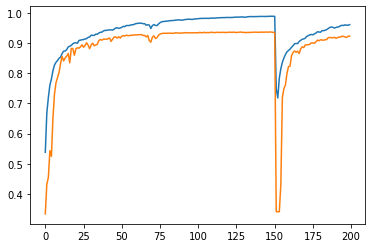

In [ ]:
#график обучения
plt.plot(history.history['dice_coef'],
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_dice_coef'],
         label='Средняя абсолютная ошибка на проверочном наборе')

In [ ]:
model.save_weights("/content/drive/MyDrive/Net weights/model200.h5")

#Проверка на изображениях которые она не видела

In [ ]:
#подгружаем модель на тест

model = unet(num_classes, (256, 256, 3))
model.load_weights("/content/drive/MyDrive/Net weights/model200.h5")

In [ ]:
images_for_test = [] #10 портретов
for filename in sorted(os.listdir('/content/drive/MyDrive/База/For test/img_10')):
    images_for_test.append(load_img(os.path.join('/content/drive/MyDrive/База/For test/img_10/', filename), target_size=(256, 256)))

segments_for_test = [] #10 готовых сегментаций
for filename in sorted(os.listdir('/content/drive/MyDrive/База/For test/seg_10')):
    segments_for_test.append(load_img(os.path.join('/content/drive/MyDrive/База/For test/seg_10/', filename), target_size=(256, 256)))

In [ ]:
predicts_for_test = []
for image in images_for_test:
  image = np.array(image).reshape((1, 256, 256, 3))
  predicts_for_test.append(pred(np.array(image)))

1/1 [==============================] - 0s 16ms/step


In [ ]:
Image1 = segments_for_test[0]
Image2 = segments_for_test[1]
Image3 = segments_for_test[2]
Image4 = segments_for_test[3]

In [ ]:
for i in range(1, 11, 3):
  print(i)

1
4
7
10


In [ ]:
#для создания нормального листа с отображением предиктов
imgs  = []
for i in range(10):
  imgs.append(i)
  imgs.append(i)
  imgs.append(i)

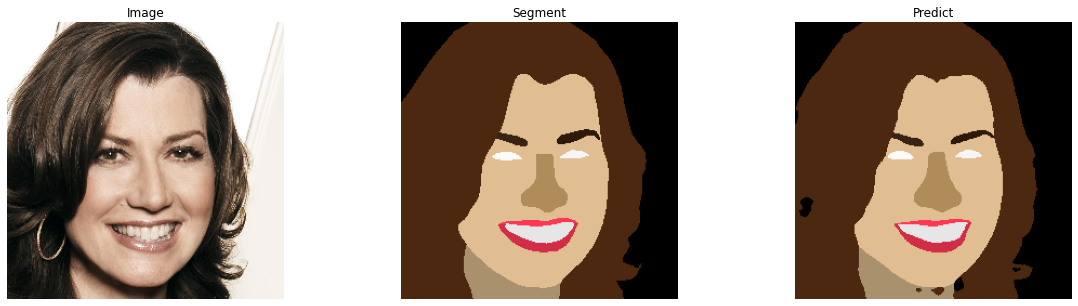

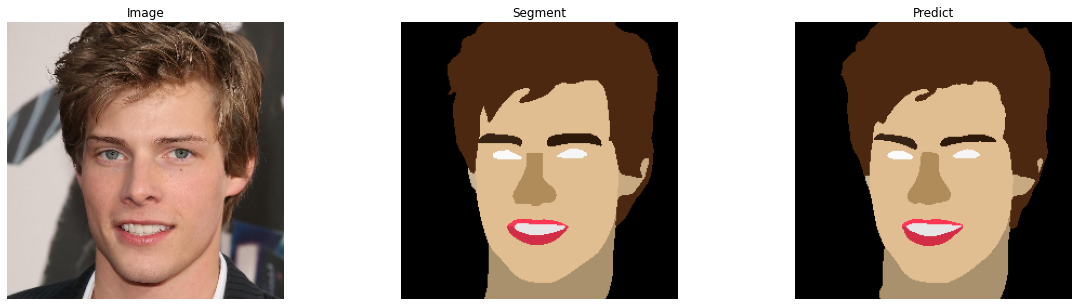

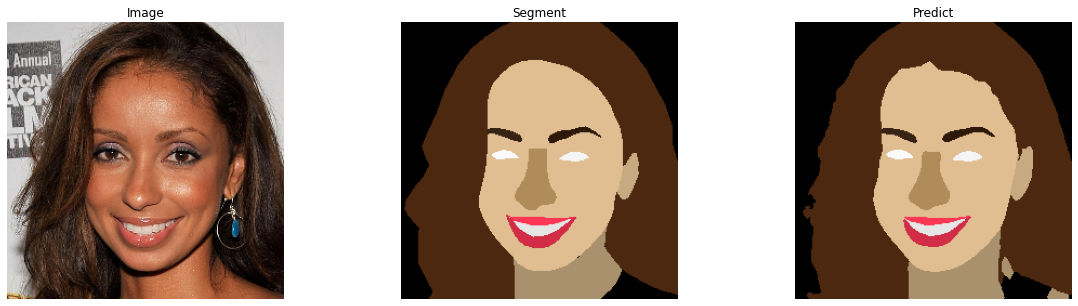

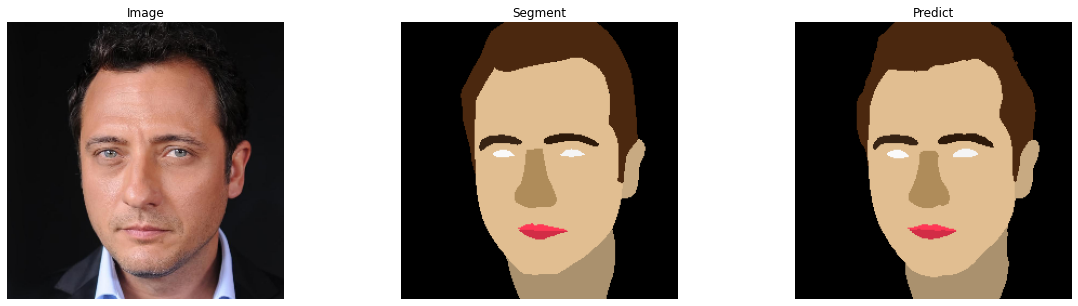

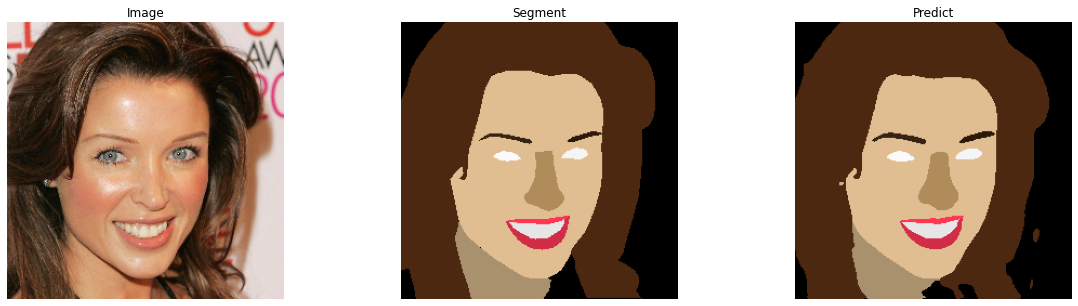

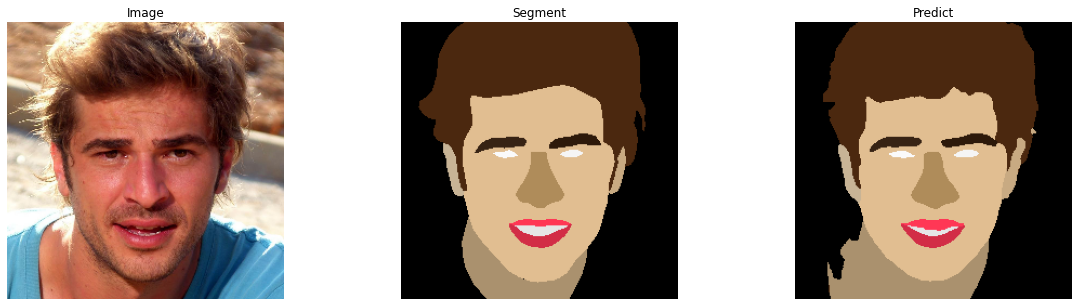

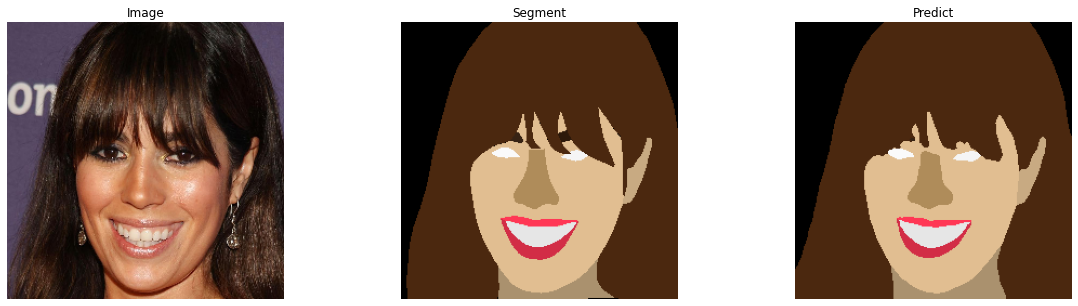

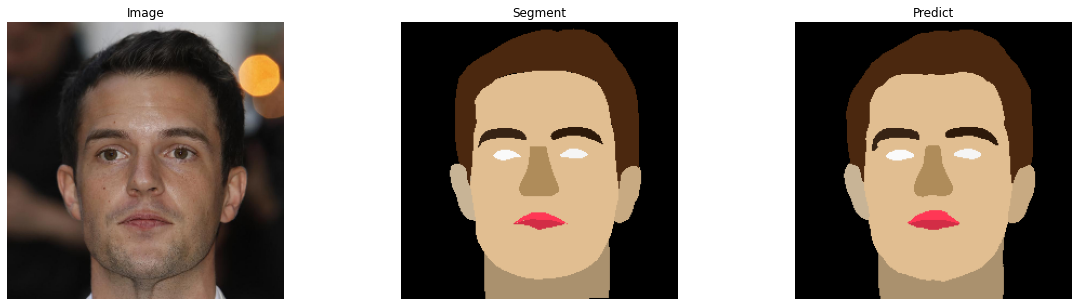

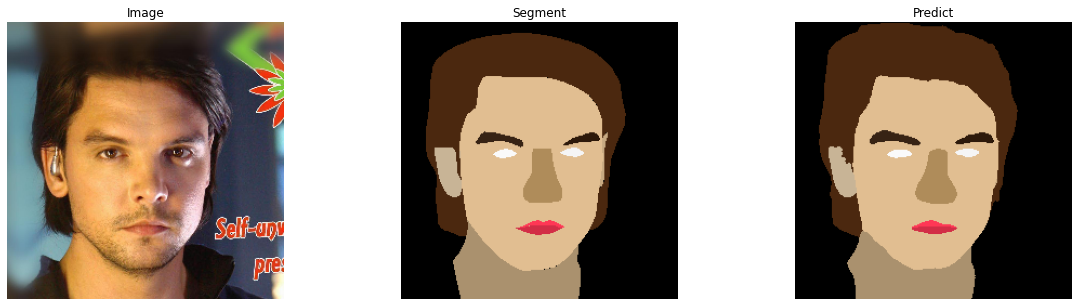

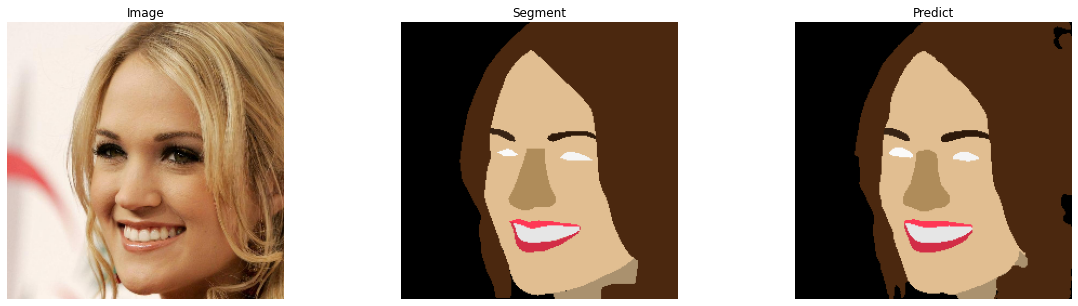

In [ ]:
#отображаем результат
rows = 10
columns = 3

for i in range(10):
  fig = plt.figure(figsize=(20, 60))

  fig.add_subplot(rows, columns, 1)
  plt.imshow(images_for_test[i])
  plt.axis('off')
  plt.title("Image")

  fig.add_subplot(rows, columns, 2)
  plt.imshow(segments_for_test[i])
  plt.axis('off')
  plt.title("Segment")

  fig.add_subplot(rows, columns, 3)
  plt.imshow(predicts_for_test[i])
  plt.axis('off')
  plt.title("Predict")

  plt.show()

  Достигнут результат в 92%. На данный момент лучше не получается. Я думаю, что такого результата достаточно для дальнейшей работы над проектом.